# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA,IncrementalPCA
import time
from sklearn.cluster import KMeans
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from collections import Counter
from operator import itemgetter
from IPython.display import Image

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';',dtype={18:'str',19:'str'})
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';',dtype={18:'str',19:'str'})
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


First, let's explore the data starting with missing values. 
Below graphs show number of columns with percentage of null values in both azdias and customers dataset. 
It can be seen that while most columns in azdias dataset have less than 20% missing values, customers dataset have more columns with more than 20% nulls.

In [3]:
azdias_null=azdias.isnull().sum()/azdias.shape[0]*100
customers_null=customers.isnull().sum()/customers.shape[0]*100

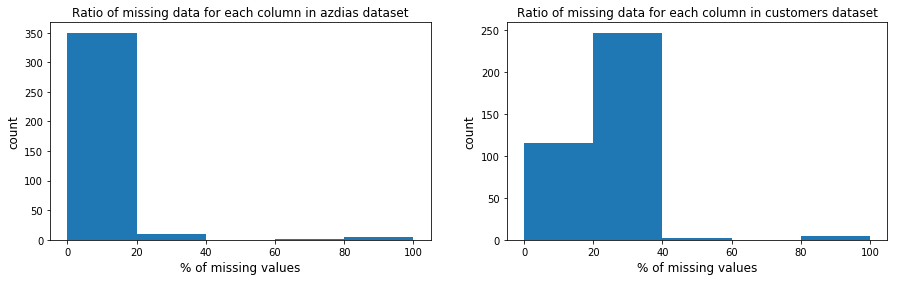

In [13]:
plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.hist(azdias_null,bins=np.arange(0,120,20))
plt.title('Ratio of missing data for each column in azdias dataset')
plt.xlabel('% of missing values',fontsize=12)
plt.ylabel('count',fontsize=12)

plt.subplot(1,2,2)

plt.hist(customers_null,bins=np.arange(0,120,20))
plt.title('Ratio of missing data for each column in customers dataset')
plt.xlabel('% of missing values',fontsize=12)
plt.ylabel('count',fontsize=12)

plt.show()
plt.savefig('number_col.png')


The same analysis with dataset rows show that again there are more rows in customers dataset with higher number of missing values.

In [14]:
customer_null_records=customers.isna().sum(axis=1).sort_values(ascending=False)/customers.shape[1]*100
azdias_null_records=azdias.isna().sum(axis=1).sort_values(ascending=False)/azdias.shape[1]*100

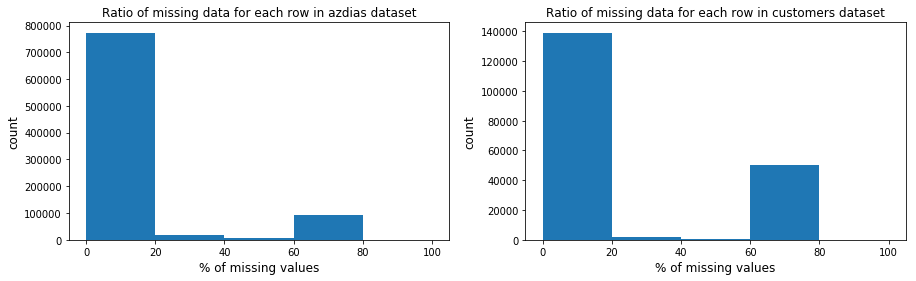

In [15]:
plt.figure(figsize=[15,4])

plt.subplot(1,2,1)
plt.hist(azdias_null_records,bins=np.arange(0,120,20))
plt.title('Ratio of missing data for each row in azdias dataset')
plt.xlabel('% of missing values',fontsize=12)
plt.ylabel('count',fontsize=12)

plt.subplot(1,2,2)

plt.hist(customer_null_records,bins=np.arange(0,120,20))
plt.title('Ratio of missing data for each row in customers dataset')
plt.xlabel('% of missing values',fontsize=12)
plt.ylabel('count',fontsize=12)

plt.show()
plt.savefig('number_row.png')


Some of the columns are dropped since there are higher level categorization of them in the dataset.

In [3]:
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

unwanted_list=['LNR','LP_LEBENSPHASE_GROB','LP_STATUS_FEIN','LP_LEBENSPHASE_FEIN','CAMEO_INTL_2015','EINGEFUEGT_AM','CAMEO_DEU_2015']
azdias.drop(unwanted_list,axis=1,inplace=True)
customers.drop(unwanted_list,axis=1,inplace=True)

print(azdias.shape)
print(customers.shape)

(891221, 359)
(191652, 359)


Below, some functions are developed for cleaning data.
- data_clean replaces some values of number of columns with more meaningful values based on my exploration in the data explanation file. Also, it replaces the values for unknown data in the excel data file with nan.
- remove_columns_nan function drops columns with more than X% missing values in df2 from df1. The reason for having two dfs is that we will need to drop the same columns from azdias and customers and we need to use one of them (in this case azdias) as a reference for dropping columns.
- remove_row_nan functions drops rows with more than X% missing values from dataframe df.
- replace_nan function is used for imputing nan values. I first categorized each column as numeric, nominal and ordinal features based on their definition. The function reads the categories from the file. For numeric columns, mean of the column is used to replace the missing values. For rest of the columns either zero or median of the column is used depending on the situation.

In [2]:
def data_clean(df):
    '''
    Clean a DataFrame. 
    Replace some values of number of columns with more meaningfull values.
    Find unknown values from table and replace them with NAN
    '''

    df['MOBI_REGIO'].replace(6,0,inplace=True)
    
    df['PRAEGENDE_JUGENDJAHRE'].replace(2,1,inplace=True)
    for i in range(3,5):
        df['PRAEGENDE_JUGENDJAHRE'].replace(i,2,inplace=True)
    for i in range(5,8):
        df['PRAEGENDE_JUGENDJAHRE'].replace(i,3,inplace=True)
    for i in range(8,10):
        df['PRAEGENDE_JUGENDJAHRE'].replace(i,4,inplace=True)
    for i in range(10,14):
        df['PRAEGENDE_JUGENDJAHRE'].replace(i,5,inplace=True)
    for i in range(14,16):
        df['PRAEGENDE_JUGENDJAHRE'].replace(i,6,inplace=True)
    
    df['ALTERSKATEGORIE_GROB'].replace(9,np.nan,inplace=True)
    df['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

    #find unknown values from information table and replace them with NAN
    #read columns with nan_values from file
    nan_values=pd.read_csv('/home/workspace/NAN-Values.csv')
    #find above columns in azdias dataset
    nan_columns=(set(df.columns)).intersection(set(nan_values['Attribute']))
    #find values that represent nan (unkown) from file
    filtered_nan_values=nan_values.loc[nan_values['Attribute'].isin(nan_columns)]
    #reset index 
    filtered_nan_values.reset_index(inplace=True)
    #split if there is two values as unknown
    values=filtered_nan_values.Value.str.split(',')
    #find and replace nan values
    for i, j in enumerate(filtered_nan_values.Attribute):
        #first value
        val_len=len(values[i])
        val1=pd.to_numeric(filtered_nan_values.Value.str.split(',')[i])[0]
        df[j].replace(val1,np.nan,inplace=True)
        #if there is a second value
        if val_len>1:
            val2=pd.to_numeric(filtered_nan_values.Value.str.split(',')[i])[1]
            df[j].replace(val2,np.nan,inplace=True)


In [3]:
def remove_columns_nan(df1,df2,percentage_column):
    '''
    Reomve columns of df1 with ratio of nan values higher than percentage_column in df2.  
    Input: 
        df1: the dataframe which it's columns will be removed
        df2: the dataframe that is reference for filtering columns with nan values, could be same as df1
        percentage_column: threshold of ratio of nan values
    '''

    Null_columns=[]
    for i in df2.columns:
        if df2[i].isnull().sum()/df2.shape[0]>percentage_column:
            Null_columns.append(i)

    df1.drop(Null_columns,axis=1,inplace=True)
#    print(df1.shape)
#    return df1


In [4]:
def remove_row_nan(df,percentage_row):
    '''
    Reomve rows of df with ratio of nan values higher than percentage_row.  
    '''

    #drop rows with more than 20% null values
    threshold=round(df.shape[1]*(1-percentage_row))
    df.dropna(thresh=threshold,axis=0,inplace=True)
#    print(df.shape)
#    return df

In [5]:
def replace_nan(df,nan_non_numeric):
    '''
    Replace NAN values:
    for numeric replace them with mean of the column
    for non numeric, replace them either with zero or median based on the nan_non_numeric input value.'''
   
    
    attr_values=pd.read_csv(r"/home/workspace/DIAS Attributes - Values 2017.csv",encoding='latin1')
    numeric_list=attr_values[attr_values['level']=='numeric']['Attribute']

    for i in numeric_list:
        try:
            df[i].fillna((df[i].mean()), inplace=True)
        except:
            pass
    if nan_non_numeric=='median':  
        for i in df.columns:
            df[i].fillna(df[i].median(), inplace=True)
    if nan_non_numeric=='zero':
        df.fillna(0, inplace=True)
        
#    print(df.shape)
#    return(df)

Finally, data_preprocessing functions calls all the above functions and run them one by one.

In [6]:
def data_preprocessing(df1,df2,percentage_column,percentage_row,nan_non_numeric):
    '''
    Calls above functions one by one, for inputs, refer to above functions.    
    '''

    print('Cleaning data...')
    data_clean(df1)
    print(df1.shape)
    print('Removing columns with more than {}% nan value...'.format(percentage_column*100))
    remove_columns_nan(df1,df2,percentage_column)
    print(df1.shape)   
    print('Removing rows with more than {}% nan value...'.format(percentage_row*100))
    remove_row_nan(df1,percentage_row)
    print(df1.shape)    
    print('Replacing remaining nan values...')
    replace_nan(df1,nan_non_numeric)
    print(df1.shape)
    print('Data is ready!')
    

Let's apply data_preprocessing to customers dataset, with reference to azdias for column removing, and 20% as the threshold for missing value removing for both columns and rows, and zero for imputing nan values in non-numeric columns. 

In [9]:
data_preprocessing(customers,azdias,0.2,0.2,'zero')

Cleaning data...
(191652, 359)
Removing columns with more than 20.0% nan value...
(191652, 343)
Removing rows with more than 20.0% nan value...
(138804, 343)
Replacing remaining nan values...
(138804, 343)
Data is ready!


Then data_preprocessing is applied to azdias dataset with itself as the reference for removing columns with missing values. The rest of the parameters are as above.

In [10]:
data_preprocessing(azdias,azdias,0.2,0.2,'zero')

Cleaning data...
(891221, 359)
Removing columns with more than 20.0% nan value...
(891221, 339)
Removing rows with more than 20.0% nan value...
(776306, 339)
Replacing remaining nan values...
(776306, 339)
Data is ready!


In [11]:
customers.to_csv('/home/workspace/customers_cleaned.csv',index=False)
azdias.to_csv('/home/workspace/azdias_cleaned.csv',index=False)

To have a look at the data, let's randomly pick 10 columns with less than 10 distinct values (for the sake of visualization) to compare the azdias and customer dataset. By running below code multiple times, it can be seen that there is clear difference between the two dataset for some of the features.

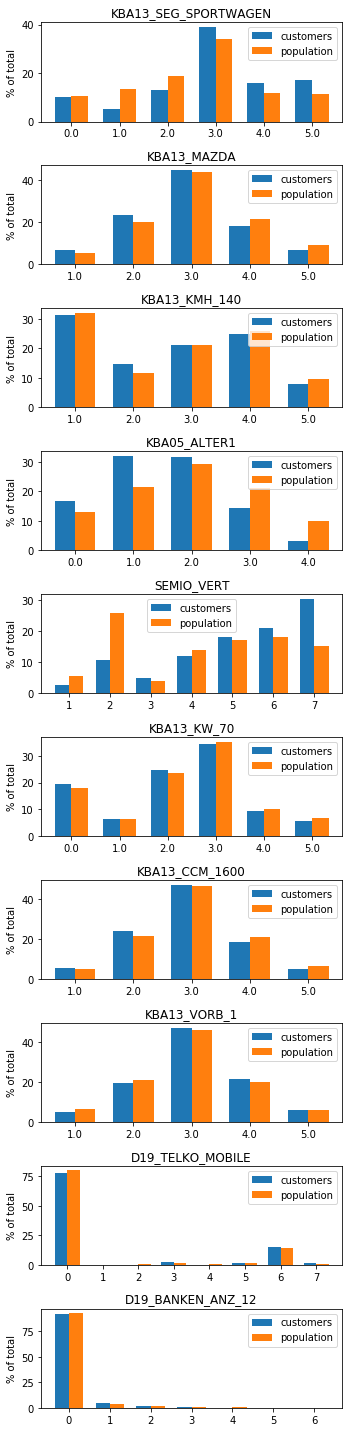

In [11]:
num_graphs=10
column_names=azdias.columns
selected_column_names=[]
counter=0

while counter<num_graphs:
    random_number=np.random.randint(1,azdias.shape[1])
    if len(azdias.iloc[:,random_number].drop_duplicates())<11:
        selected_column_names.append(column_names[random_number])
    counter+=1
plt.figure(figsize=[5,20])
plt.subplots_adjust(hspace = 0.3)

for i,col in enumerate(selected_column_names):
    a=pd.DataFrame(customers.groupby(col).size()/customers.shape[0]*100,columns=['customers'])
    b=pd.DataFrame(azdias.groupby(col).size()/azdias.shape[0]*100,columns=['population'])
    c=pd.concat([a,b],axis=1)
    labels=list(c.index)
    x=np.arange(len(labels))
    width=0.35
    plt.subplot(num_graphs,1,i+1)
    rects1=plt.bar(x-width/2,c['customers'],0.35,label='customers')
    rects2=plt.bar(x+width/2,c['population'],0.35,label='population')
    plt.title(col)
    plt.legend()
    plt.ylabel('% of total')
    plt.xticks(x,labels)
    plt.tight_layout()


plt.show()

In [18]:
customers=pd.read_csv('/home/workspace/customers_cleaned.csv',dtype={11:'str',12:'str'})
azdias=pd.read_csv('/home/workspace/azdias_cleaned.csv',dtype={11:'str',12:'str'})
#customers.to_csv('/home/workspace/customers_cleaned2.csv',index=False)
#azdias.to_csv('/home/workspace/azdias_cleaned2.csv',index=False)

Below code is for defining numeric, ordinal and nominal values. First, I limit columns to the ones with definition in the attached excel file, the reason for this is first to reduce the size of the dataset, also since we are describing the data at this point, columns with no definition will not have any interpretation benefit. 
Also, from nominal features, only the ones that have 5 or fewer categories are selected for the unsupervised learning part, to reduce size. Having features with high number of categories and converting them with one hot encoder will make the data frame size too big to handle.

In [31]:
attr_values=pd.read_csv(r"/home/workspace/DIAS Attributes - Values 2017.csv",encoding='latin1')
columns=list((set(azdias.columns)).intersection(set(attr_values['Attribute'])))
customers=customers[columns]
azdias=azdias[columns]

numeric_list=attr_values[attr_values['level']=='numeric']['Attribute']
ordinal_list=attr_values[attr_values['level']=='ordinal']['Attribute']
nominal_list=attr_values[attr_values['level']=='nominal']['Attribute']

numeric_list=list(set(numeric_list).intersection(set(columns)))
nominal_list=list(set(nominal_list).intersection(set(columns)))
ordinal_list=list(set(ordinal_list).intersection(set(columns)))

In [19]:
nominal_list_short=[]
for i in nominal_list:
    if len(azdias[i].value_counts())<6:
        nominal_list_short.append(i) 

One hot encoding method is used to replace nominal columns. 
Then columns of azdias are scaled with standard method and then customers dataset is also scaled by scaler fitted to azdias.

In [20]:
nominal_dummies_azdias=pd.get_dummies(azdias[nominal_list_short].astype('object'))#.dtypes
nominal_dummies_customers=pd.get_dummies(customers[nominal_list_short].astype('object'))#.dtypes

azdias.drop(nominal_list, axis=1, inplace = True)
customers.drop(nominal_list, axis=1, inplace = True)

azdias = pd.concat([azdias,nominal_dummies_azdias], axis = 1)
customers = pd.concat([customers,nominal_dummies_customers], axis = 1)
#len(ordinal_list)
print(azdias.shape)
print(customers.shape)

(776306, 289)
(138804, 289)


In [21]:
scaler = StandardScaler()
azdias = pd.DataFrame(scaler.fit_transform(azdias), columns = azdias.columns)
print(azdias.shape)

(776306, 289)


In [22]:
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)
customers.shape

(138804, 289)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

do_pca function does principal component analysis with n component to a dataframe. It is being used to for dimension reduction. First, we start from a PCA with all variables, and draw the scree plot to see at what number of components 95% of variance is explained. We pick that threshold for the dimension of the dataframe. In this case, the dimension is reduced from 289 to 180.

In [23]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca


scree_plot function is used to create a scree plot associated with the principal components.

In [24]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


First, PCA is applied to azdias dataset with n equal all columns and the scree plot is drawn. It can be seen that having 170-180 components will explain 95% of the variance. We'll go with 180 components.

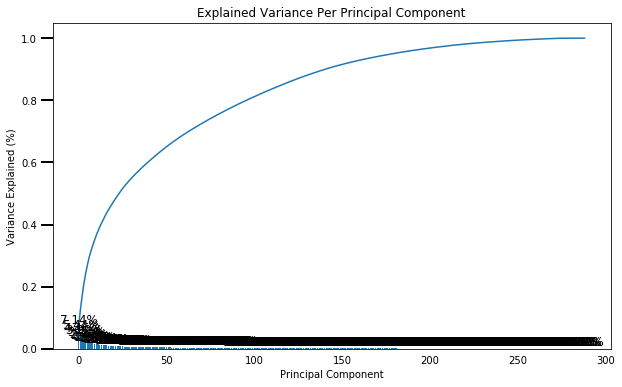

In [26]:
azdias_pca_all, azdias_X_pca_all = do_pca(None, azdias)
scree_plot(azdias_pca_all)

Here we re-fit a PCA instance to perform the decided-on transformation.

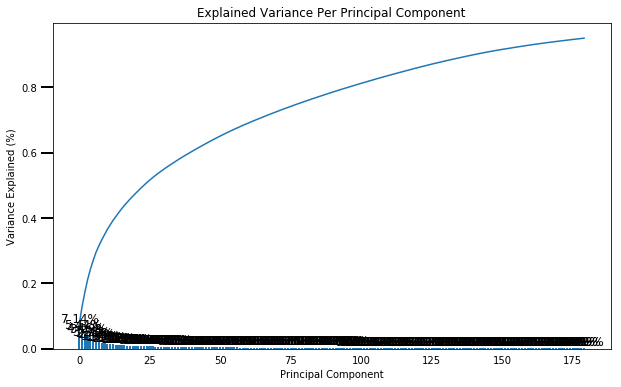

In [29]:
azdias_pca_180, azdias_X_pca_180 = do_pca(180, azdias)
scree_plot(azdias_pca_180)

Now, let's check to components and see if we can interpret them from the weights. 
The interpretation might not be straightforward since the feature definitions are not very clear, however, for instanced we could say:
- Component 1 is related to high income, business units with high share of car.
- Component 2 is related of share of BMW and Mercedes
- Component 3 is related to share of different types of cars
- Component 4 is related to transactions 
- Component 5 is related to level of being traditional, cultural and religious minded

In [30]:
def pca_results(full_dataset, pca, component_number):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results where figure 1 shows all features sorted
    and figure 2 shows the top 3 negative and positive features.
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization for 1st figure (all columns sorted)
    fig1, ax1 = plt.subplots(figsize = (15,8))

    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().plot(ax = ax1, kind = 'bar');
    ax1.set_ylabel("Feature Weights")
    ax1.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=90)
   
    # Create a bar plot visualization for 2nd figure (top and bottom 3 columns)
    fig2, ax2 = plt.subplots(figsize = (6,3))
    
    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().iloc[[0, 1, 2,-3, -2, -1]].plot(ax = ax2, kind = 'bar');
    ax2.set_ylabel("Feature Weights")
    ax2.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=90)

    # Return a concatenated DataFrame
    #return pd.concat([variance_ratios, components], axis = 1)


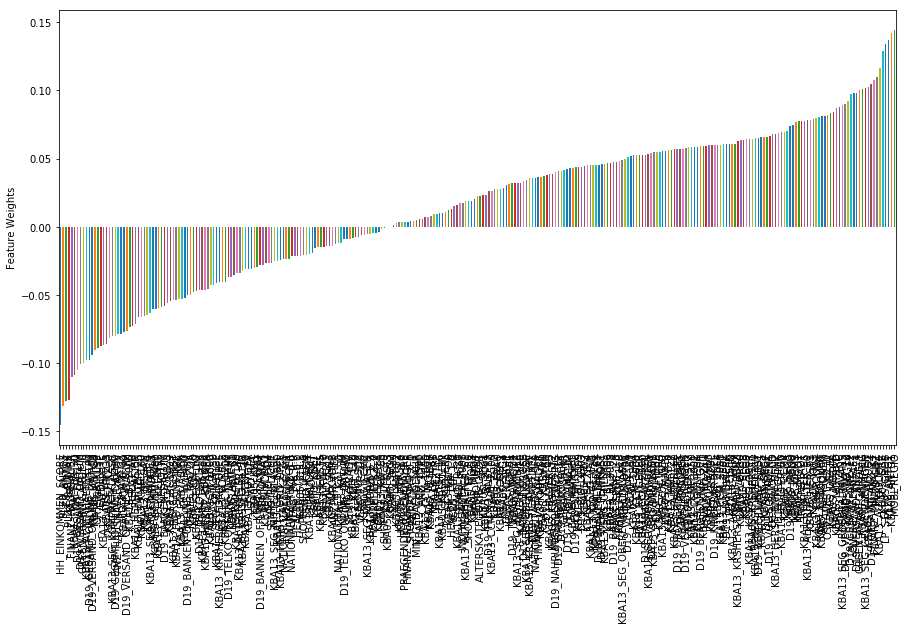

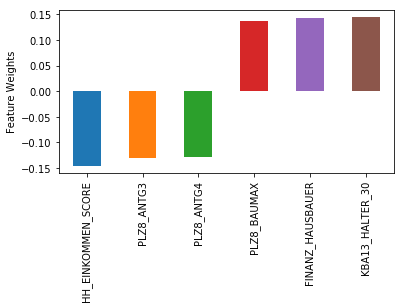

In [31]:
pca_results(azdias, azdias_pca_180, component_number = 1)


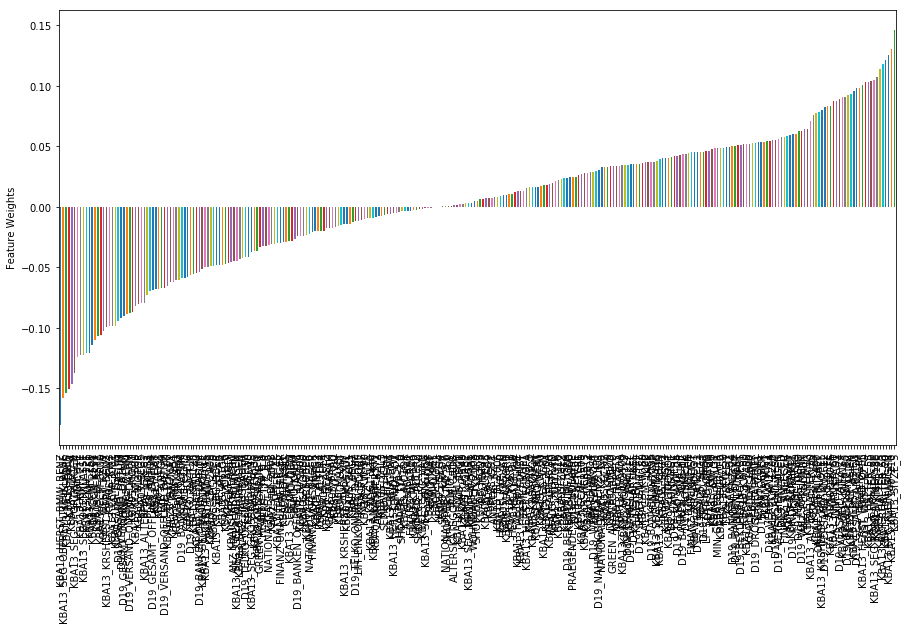

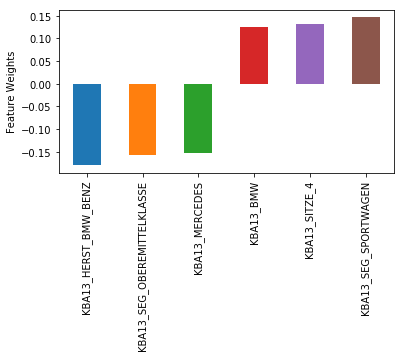

In [32]:
pca_results(azdias, azdias_pca_180, component_number = 2)


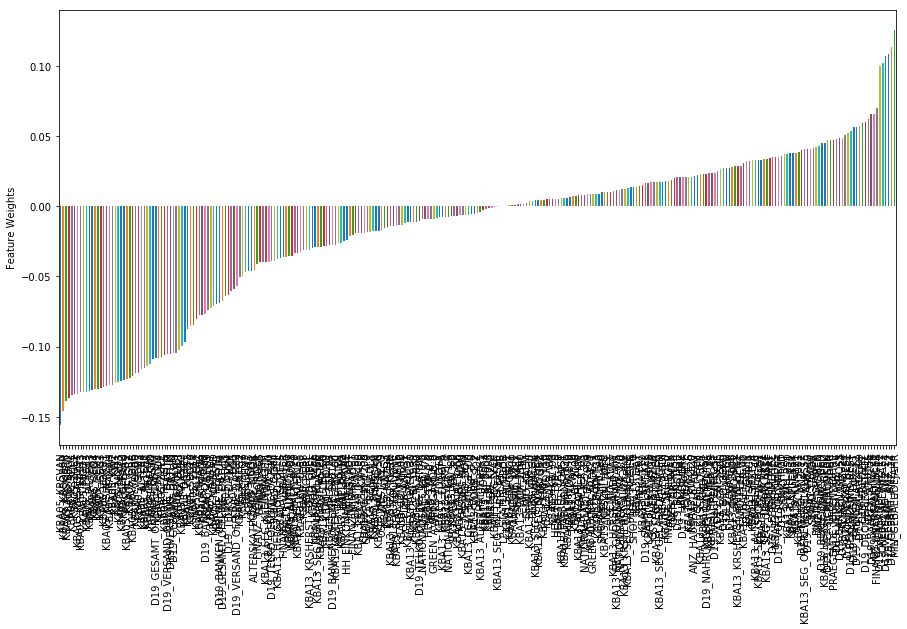

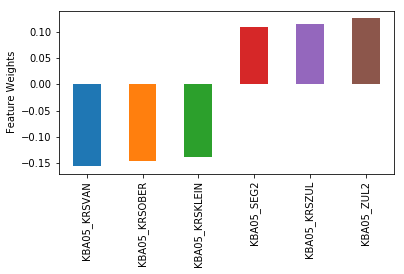

In [33]:
pca_results(azdias, azdias_pca_180, component_number = 3)


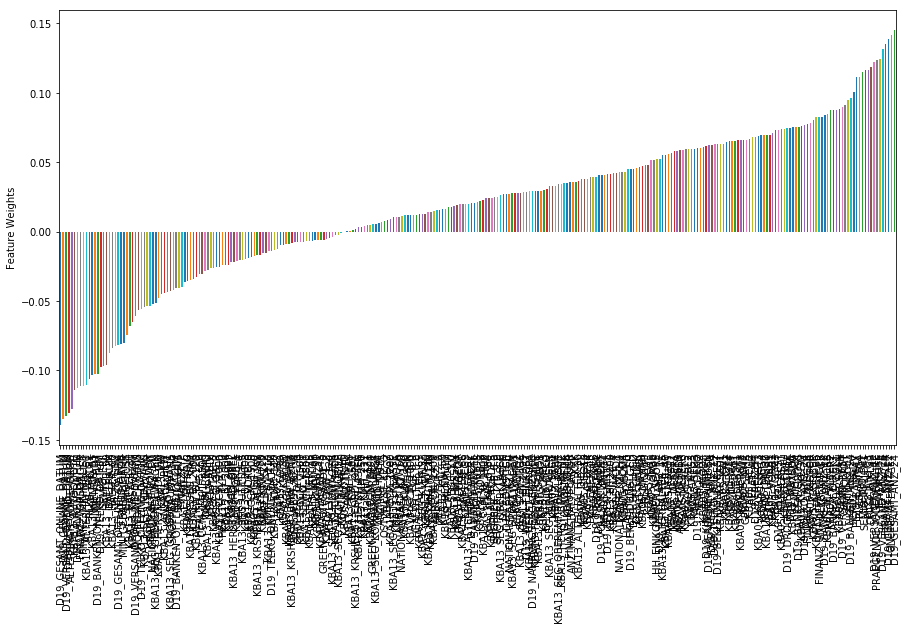

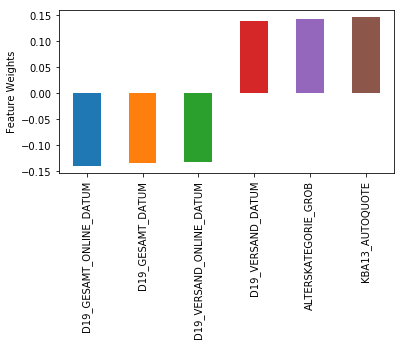

In [34]:
pca_results(azdias, azdias_pca_180, component_number = 4)


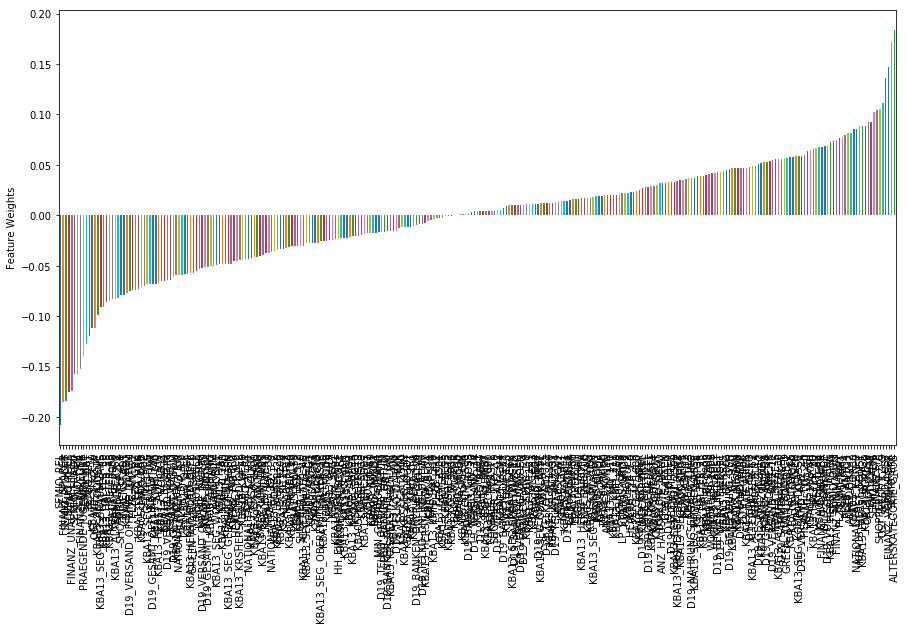

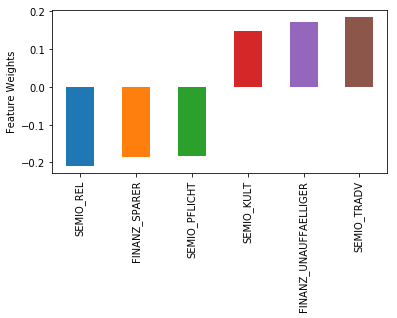

In [35]:
pca_results(azdias, azdias_pca_180, component_number = 5)


Now, K-mean method is being used for clustering azdias dataset. First, we should pick the K, based on the elbow plot below, 8 cluster looks to be sufficient.

In [36]:
def elbow_plot(data, start_K, end_K, step):
    '''
    Generate an elbow plot to find optimal number of clusters
    graphing K values from start_K to end_K every step value
    
    INPUT: 
        data: Demographics DataFrame
        start_K: Inclusive starting value for cluster number
        end_K: Exclusive stopping value for cluster number
        step: Step value between start_K and end_K
    OUTPUT: Trimmed and cleaned demographics DataFrame
    '''
    score_list = []

    for i in range(start_K, end_K, step):
        print(i)
        start = time.time()
        kmeans = KMeans(i)
        model = kmeans.fit(data)
        score = model.score(data)
        score_list.append(abs(score))
        end = time.time()
        elapsed_time = end - start
        print(elapsed_time)

    plt.plot(range(start_K, end_K, step), 
    score_list, linestyle='--', marker='o', color='b');
    plt.xlabel('# of clusters K');
    plt.ylabel('Sum of squared errors');
    plt.title('SSE vs. K');
    plt.savefig('elbow_plot.png')


1
18.30394411087036
3
197.31516695022583
5
217.21674752235413
7
271.4156949520111
9
473.05425691604614
11
578.5891592502594
13
624.0887913703918
15
794.4308075904846
17
869.6696577072144
19
826.3713827133179


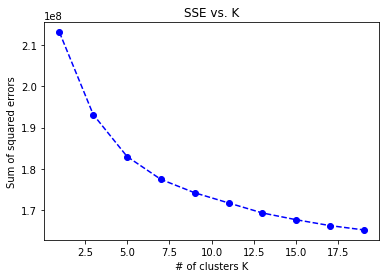

In [37]:
elbow_plot(azdias_X_pca_180, 1, 20, 2)


The K-mean model with K=8 is fit to azdias dataset and is used to make prediction of the cluster labels. Then the same model is used to transform and predict clusters for customers dataset.

In [39]:
azdias_kmeans = KMeans(8)
azdias_model = azdias_kmeans.fit(azdias_X_pca_180)
azdias_labels = azdias_model.predict(azdias_X_pca_180)
customers_pca_180 = azdias_pca_180.transform(customers)
customers_labels = azdias_model.predict(customers_pca_180)

Below, we calculate the proportions of each cluster for the azdias dataset. We also include the data that was initially removed due to too many NaNs when calculating the proportions and include this data as cluster -1.
Then we do the same to customers dataset. And finally compare the distribution of the population over the clusters for azdias and customers dataset.

In [49]:
general_pop = 891221

azdias_counter = Counter(azdias_labels)
azdias_proportions = [(i, azdias_counter[i] / general_pop * 100.0) for i in azdias_counter]
azdias_proportions.sort(key=itemgetter(0))
azdias_proportions = np.array(azdias_proportions)

dropped_gen_pop = 100 - azdias_proportions[:, 1].astype(np.float).sum()

azdias_proportions = np.insert(azdias_proportions, 0, values=[-1, dropped_gen_pop], axis=0)
azdias_proportions


array([[ -1.        ,  12.8941082 ],
       [  0.        ,   4.37803867],
       [  1.        ,  10.85802511],
       [  2.        ,  16.58230675],
       [  3.        ,   7.44012989],
       [  4.        ,   3.53357921],
       [  5.        ,  12.51417998],
       [  6.        ,  20.72482583],
       [  7.        ,  11.07480636]])

In [50]:
cust_pop = 191652

customers_counter = Counter(customers_labels)
customers_proportions = [(i, customers_counter[i] / cust_pop * 100.0) for i in customers_counter]
customers_proportions.sort(key=itemgetter(0))
customers_proportions = np.array(customers_proportions)

dropped_cust_pop = 100 - customers_proportions[:, 1].astype(np.float).sum()

customers_proportions = np.insert(customers_proportions, 0, values=[-1, dropped_cust_pop], axis=0)
customers_proportions


array([[ -1.        ,  27.57497965],
       [  0.        ,   2.37826895],
       [  1.        ,  17.73422662],
       [  2.        ,   5.31849394],
       [  3.        ,   2.40279256],
       [  4.        ,   0.89067685],
       [  5.        ,  22.81844176],
       [  6.        ,  18.13547471],
       [  7.        ,   2.74664496]])

In [51]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
representation_ratio = customers_proportions[:, 1]/azdias_proportions[:, 1]


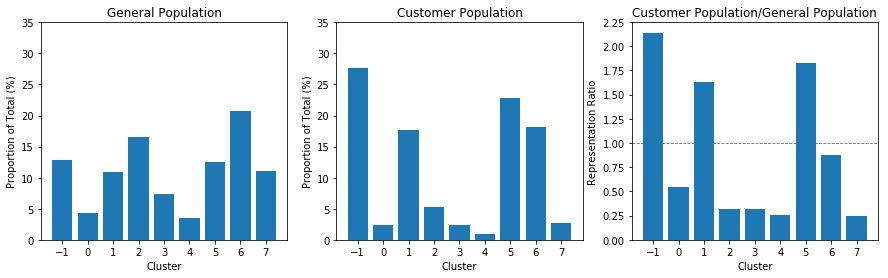

In [52]:
# Plot the proportions for the general population, the customer population,
# and the ratio of customer/general populations.
plt.figure(figsize=(15, 4))

ax1 = plt.subplot(131)
ax1.bar(azdias_proportions[:, 0], azdias_proportions[:, 1])
ax1.set_xticks(azdias_proportions[:, 0])
ax1.set_ylim(ymax = 35)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
plt.title('General Population')

ax2 = plt.subplot(132)
ax2.bar(customers_proportions[:, 0], customers_proportions[:, 1])
ax2.set_xticks(azdias_proportions[:, 0])
ax2.set_ylim(ymax = 35)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
plt.title('Customer Population')

ax3 = plt.subplot(133)
ax3.bar(azdias_proportions[:, 0], representation_ratio)
ax3.set_xticks(azdias_proportions[:, 0])
ax3.set_xlabel("Cluster")
ax3.set_ylabel("Representation Ratio")
ax3.axhline(y=1, linestyle = "--", linewidth = 0.8)
plt.title('Customer Population/General Population')

plt.savefig('population_proportions.png');


Above graphs shows that people in clusters 1 and 5 are more likely to become customers. If we look at the components with highest and lowest weights for these two clusters (below), we can see in both clusters, component 1 has the highest weight. As mentioned before, component 1 looks to be more related high income, business related people. So maybe focusing on these groups and looking more closely to component 1 can provide insights on potential customers.

In [60]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

weights_1 = azdias_model.cluster_centers_[1]
components_1 = list(range(1, 181))
cluster_components_1 = pd.DataFrame({'Weights': weights_1, 'Component': components_1})
print(cluster_components_1.sort_values('Weights',ascending=False).head(1))
print(cluster_components_1.sort_values('Weights',ascending=False).tail(1))


    Weights  Component
0  3.041155          1
    Weights  Component
1 -5.565988          2


In [62]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

weights_5 = azdias_model.cluster_centers_[5]
components_5 = list(range(1, 181))
cluster_components_5 = pd.DataFrame({'Weights': weights_5, 'Component': components_5})
print(cluster_components_5.sort_values('Weights',ascending=False).head(1))
print(cluster_components_5.sort_values('Weights',ascending=False).tail(1))


    Weights  Component
0  6.037068          1
    Weights  Component
5 -0.582453          6


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [27]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';',dtype={18:'str',19:'str'})

mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [28]:
attr_values=pd.read_csv(r"/home/workspace/DIAS Attributes - Values 2017.csv",encoding='latin1')

unwanted_list=['LP_LEBENSPHASE_GROB','LP_STATUS_FEIN','LP_LEBENSPHASE_FEIN','CAMEO_INTL_2015','ALTER_KIND4','ALTER_KIND3','ALTER_KIND2','ALTER_KIND1','TITEL_KZ','KK_KUNDENTYP','KBA05_BAUMAX','AGER_TYP','EXTSEL992','EINGEFUEGT_AM']

mailout_train.drop(unwanted_list,axis=1,inplace=True)
print(mailout_train.shape)


(42962, 353)


In [29]:
def data_preprocessing2(df,percentage_row,nan_non_numeric):
    print('Cleaning data...')
    data_clean(df)
    print('Removing rows with more than {}% nan value...'.format(percentage_row*100))
    remove_row_nan(df,percentage_row)
    print('Replacing remaining nan values...')
    replace_nan(df,nan_non_numeric)
    print('Data is ready!')


Data processing is done here, without removing columns with nan values is the dataframe.

In [33]:
data_preprocessing2(mailout_train,0.2,'zero')

Cleaning data...
Removing rows with more than 20.0% nan value...
Replacing remaining nan values...
Data is ready!


X and y are defined to be used in supervised learning model later.

In [34]:
X=mailout_train.drop(['RESPONSE','LNR'],axis=1)#[columns]
y = mailout_train['RESPONSE']
y.shape, X.shape

((34876,), (34876, 351))

Here we keep all the columns (except the ones removed at the very top) to keep as much information as possible. This is possible since the dataset is smaller here. All the columns with data type 'object' are taken as nominal columns.

In [ ]:
columns=list((set(mailout_train.columns)).intersection(set(attr_values['Attribute'])))


numeric_list=attr_values[attr_values['level']=='numeric']['Attribute']
ordinal_list=attr_values[attr_values['level']=='ordinal']['Attribute']
nominal_list=attr_values[attr_values['level']=='nominal']['Attribute']

numeric_list=list(set(numeric_list).intersection(set(columns)))
nominal_list=list(set(nominal_list).intersection(set(columns)))
ordinal_list=list(set(ordinal_list).intersection(set(columns)))

for i in X.columns:
    if X[i].dtype=='object':
        print(i)
        nominal_list.append(i)
nominal_list=list(set(nominal_list))
len(nominal_list)


One hot encoder is done to all nominal values. The number of featues increases from 284 to 485 since we have kept nominal values with lots of categories.
Next, standard scaler is applied to the dataset.

In [37]:
nominal_dummies_X=pd.get_dummies(X[nominal_list].astype('object'))
X.drop(nominal_list, axis=1, inplace = True)
X = pd.concat([X,nominal_dummies_X], axis = 1)
print(X.shape)


(34876, 564)


In [38]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
print(X.shape)


(34876, 564)


Below function is used to fit different types of classifier to (X,y) and report back the run time and area under the curve for comparison.

In [39]:
def classifier_roc(clf, param_grid, X, y=y):
    """
    Fit a classifier using GridSearchCV and calculates ROC AUC
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - prints elapsed time and ROX AUC
    """
        
    start = time.time()
    
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    end = time.time()
    print(end-start)

    print(grid.best_score_)
    
    return grid.best_estimator_


Logistic Regression, Random Forest, Ada Boost, GB and SVC were applied to the features and lables in (X,y). Gradient Boosting method had slightly higher area under the curve than Ada boost but it took longer to run. Also, while area under the curve was not very high for Random Forest model, it ran very fast. I picked Ada Boost and Random Forest model for further analysis and tried to improve them using hyperparameter tuning. 

In [50]:

# LogisticRegression
logreg = LogisticRegression()
print(classifier_roc(logreg, {},X))

# RandomForestClassifier
rfc = RandomForestClassifier()
print(classifier_roc(rfc, {},X))

# AdaBoostClassifier
ada = AdaBoostClassifier()
print(classifier_roc(ada, {},X))

# GradientBoostingClassifier
gbc = GradientBoostingClassifier()
print(classifier_roc(gbc, {},X))

# SupportVectorMachine
svc = SVC()
print(classifier_roc(svc, {},X))


149.99502682685852
0.656520871363
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
8.205735683441162
0.529067520791
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
97.54759573936462
0.745303967555
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
343.0859160423279
0.774243539472
GradientBoostingClassifier(criterion='friedman_mse', in

Hyperparamet tuning for Ada Boost model is done here. The best model is identified.

In [2]:
start = time.time()


param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.01, 0.1, 1.0],
             'n_estimators': [20, 50, 100]}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X, y)
results=pd.DataFrame(grid.cv_results_)[['params','mean_test_score','rank_test_score']]


end = time.time()
cv_time = end - start
print(cv_time)


679


In [24]:
results.sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
4,"{'algorithm': 'SAMME.R', 'learning_rate': 0.1,...",0.769206,1
3,"{'algorithm': 'SAMME.R', 'learning_rate': 0.1,...",0.768059,2
2,"{'algorithm': 'SAMME.R', 'learning_rate': 0.01...",0.768009,3
5,"{'algorithm': 'SAMME.R', 'learning_rate': 0.1,...",0.766157,4
1,"{'algorithm': 'SAMME.R', 'learning_rate': 0.01...",0.765053,5
6,"{'algorithm': 'SAMME.R', 'learning_rate': 1.0,...",0.759199,6
7,"{'algorithm': 'SAMME.R', 'learning_rate': 1.0,...",0.751196,7
8,"{'algorithm': 'SAMME.R', 'learning_rate': 1.0,...",0.730725,8
0,"{'algorithm': 'SAMME.R', 'learning_rate': 0.01...",0.709337,9


In [25]:
print(grid.best_score_)
print(grid.best_estimator_)


0.769206442634
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)


Hyper parameter tuning for Random Forest model shows that with approperiate parameters, the area under the curve can be as high as Ada boost model.

In [20]:
start = time.time()


param_grid = {'max_depth': [3,10, 20, 30],
              'max_features': ['auto', 'sqrt'],
             'n_estimators': [10, 100, 200]}

grid = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X, y)
results=pd.DataFrame(grid.cv_results_)[['params','mean_test_score','rank_test_score']]


end = time.time()
cv_time = end - start
print(cv_time)
results.sort_values('rank_test_score')

2439.6625657081604


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py

,params,mean_test_score,rank_test_score
1,"{'max_depth': 3, 'max_features': 'auto', 'n_es...",0.748937,1
2,"{'max_depth': 3, 'max_features': 'auto', 'n_es...",0.746985,2
7,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.744029,3
6,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.742736,4
3,"{'max_depth': 3, 'max_features': 'auto', 'n_es...",0.742447,5
5,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.740880,6
11,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.707603,7
15,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.706628,8
10,"{'max_depth': 10, 'max_features': 'auto', 'n_e...",0.699044,9
14,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.688240,10


In [24]:
results.sort_values('rank_test_score')['params'][1]

{'max_depth': 3, 'max_features': 'auto', 'n_estimators': 100}

With all the changes I tried, still the base case Gradient Boosting model provided higher area under the curve. So I decided to use this model as classifier. 

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [41]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';',dtype={18:'str',19:'str'})
mailout_test.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [42]:
attr_values=pd.read_csv(r"/home/workspace/DIAS Attributes - Values 2017.csv",encoding='latin1')

unwanted_list=['LP_LEBENSPHASE_GROB','LP_STATUS_FEIN','LP_LEBENSPHASE_FEIN','CAMEO_INTL_2015','ALTER_KIND4','ALTER_KIND3','ALTER_KIND2','ALTER_KIND1','TITEL_KZ','KK_KUNDENTYP','KBA05_BAUMAX','AGER_TYP','EXTSEL992','EINGEFUEGT_AM']

mailout_test.drop(unwanted_list,axis=1,inplace=True)
print(mailout_test.shape)


(42833, 352)


Keep LNR columns for Kaggle file.

In [43]:
test_LNR = mailout_test['LNR']
X_test=mailout_test.drop('LNR',axis=1)
X_test.shape


(42833, 351)

In data preprocessing, row cleaning is skipped since we need to do prediction for all data entries.

In [45]:
def data_preprocessing3(df,nan_non_numeric):
    print('Cleaning data...')
    data_clean(df)
    print('Replacing remaining nan values...')
    replace_nan(df,nan_non_numeric)
    print('Data is ready!')
   

In [46]:
data_preprocessing3(X_test,'zero')

Cleaning data...
Replacing remaining nan values...
Data is ready!


One hot encoder and standard scaler is performed.

In [49]:
nominal_dummies_X_test=pd.get_dummies(X_test[nominal_list].astype('object'))
X_test.drop(nominal_list, axis=1, inplace = True)
X_test = pd.concat([X_test,nominal_dummies_X_test], axis = 1)
print(X_test.shape)


(42833, 568)


In [51]:
scaler = StandardScaler()
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X_test.columns)
print(X_test.shape)


(42833, 568)


Add missing columns in X from X_test with values of zero.

In [52]:
for i in list(set(X_test.columns)-set(X.columns).intersection(set(X_test.columns))):
    X[i]=0


Train and test GB model with parameters of the base parameters. Make Kaggle file with the prediction and LNR and save it.

In [53]:
gbc = GradientBoostingClassifier()
best_model=classifier_roc(gbc, {},X)

best_model.fit(X, y)
preds = best_model.predict_proba(X_test)
preds[:10]


344.4590585231781
0.776017134849


array([[ 0.96371359,  0.03628641],
       [ 0.97989637,  0.02010363],
       [ 0.98761851,  0.01238149],
       [ 0.9968774 ,  0.0031226 ],
       [ 0.99614672,  0.00385328],
       [ 0.99129817,  0.00870183],
       [ 0.99576319,  0.00423681],
       [ 0.976108  ,  0.023892  ],
       [ 0.97903207,  0.02096793],
       [ 0.98853479,  0.01146521]])

In [54]:
# Generate a csv file to be submitted to Kaggle with the LNR id and prediction of response as columns.
# Use second column of the array as the probabilities to be entered (probability of a positive response).
# Print the first few lines of the kaggle dataframe.
kaggle = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':preds[:, 1]})
kaggle.to_csv('kaggle.csv', index = False)
kaggle.head()


,LNR,RESPONSE
0,1754,0.036286
1,1770,0.020104
2,1465,0.012381
3,1470,0.003123
4,1478,0.003853
